### Interpretations of the Data Part 2

In this script, we attempted to make sense of the data 


1) We tried labelling the genres (PG, PG-13, R) and then plotted Gross vs IMdB Scores against all movies. Implemented a KDE (assummed the kernel function Tophat), but it did not fit the data well

2) Tried inputting a kNN with the same labelled data using different weighting schemes (uniform and distance). However, it was hard to discern and interpret. Hence, did not reveal much.

3) Tried using a Naive Bayes Classifier, however we mislabled almost half the data! 

None of the above yielded anything pertinent to explaining our data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Data Input

In [2]:
# Read in the data
data = pd.read_csv("movie_metadata.csv")

# Drop the missing data
data = data.dropna()

# Set content rating labels
movie_content_rating = ['PG', 'PG-13', 'R']

# Filter data via the content rating above
data = data.loc[data['content_rating'].isin(movie_content_rating)]

In [3]:
# Find the gross and duration values
gross = data['gross'].values
duration = data['duration'].values

# Set up our design matrix
X = np.zeros((gross.shape[0], 2))
X[:, 0] = duration
X[:, 1] = gross

In [4]:
# Get the content ratings values 
content_rate = data['content_rating'].values

# Set up the unique labels 
unique_labels = movie_content_rating

# Create an empty labels array with legnth = content_rate array
labels = np.zeros(len(content_rate))

# Count to check for how many movies are PG, PG-13, and R in the whole dataset] 
for i in range(content_rate.size):
    labels[i] = sum(((unique_labels[j] == content_rate[i]) * j for j in range(len(unique_labels))))

In [5]:
from sklearn.neighbors import KernelDensity

#Initiaite the kenerl density function and assume our data is tophat distributed
kde = KernelDensity(kernel='tophat').fit(duration.reshape(-1,1))

# Create a sample array shape (<length of duration>, 1)
samples = np.linspace(0, 300, duration.shape[0])[:, np.newaxis]

#save the log densities
log_density = kde.score_samples(samples)

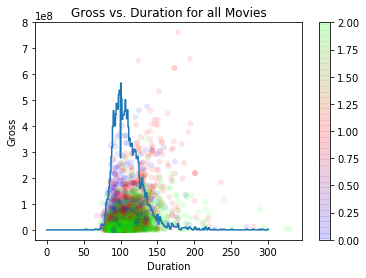

In [6]:
fig = plt.figure()
plt.scatter(duration, gross, edgecolor='none', c=labels, cmap='brg', alpha=0.1)
plt.plot(samples, np.exp(log_density)*20000000000)
plt.colorbar()
plt.xlabel('Duration')
plt.ylabel('Gross')
plt.title('Gross vs. Duration for all Movies')
plt.show()

# $k$ Nearest Neighbors

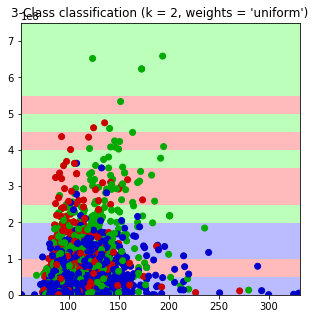

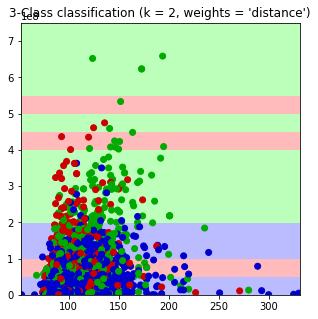

In [7]:
from sklearn import neighbors

# create color maps
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB', '#BBBBFF'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00', '#0000CC'])

n_neighbors = 2

# import some data to play with
X_train = X
y = labels

h = 10  # step size in the mesh

x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h/100),
                     np.arange(y_min, y_max, h*5000000))
grid = np.c_[xx.ravel(), yy.ravel()]

for weights in ['uniform', 'distance']:
    
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, y)
    
    ZZ = clf.predict(grid)
    ZZ = ZZ.reshape(xx.shape) # 2-D grid layout

    # Plot the decision boundary. For that, we will assign a color to each grid point
    plt.figure(figsize=(5,5))
    plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:,0], X[:,1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

# Naive Bayes

In [8]:
# calculate feature means and variances for each class
classes = np.unique(labels)
param = dict()  # we save them in this dictionary
for k in classes:
    members = (labels == k) # boolean array
    num = members.sum()    # True:1, False:0
    prior = num / float(labels.size)
    the_X = X[members,:] # slice out members
    mu = the_X.mean(axis=0)      # calc mean
    the_X -= mu
    var = (the_X*the_X).sum(axis=0) / (X[:,0].size-1)
    param[k] = (num, prior, mu, var) # save results
    if True: print (k, mu, var)

0.0 [1.04934629e+02 7.73519221e+07] [5.91773247e+01 1.06782300e+15]
1.0 [1.12235474e+02 6.89651186e+07] [1.64206402e+02 2.66526254e+15]
2.0 [1.11147059e+02 3.21498388e+07] [2.56893153e+02 7.73492225e+14]


In [9]:
# init predicted values
k_pred = -1 * np.ones(labels.size)

# evaluate posterior for each point and find maximum
for i in range(labels.size):
    pmax, kmax = -1, None   # initialize to nonsense values
    for k in classes:
        num, prior, mu, var = param[k] # grab parameters from dictionary
        diff = X[i,:] - mu
        d2 = diff*diff / (2*var) 
        p = prior * np.exp(-d2.sum()) / np.sqrt(np.prod(2*pi*var))
        if p > pmax: # Save which ever one creating the highest probability
            pmax = p
            kmax = k
    k_pred[i] = kmax

print("Number of mislabeled points out of a total {} points : {}".format(labels.size, sum(labels!=k_pred)))

Number of mislabeled points out of a total 3574 points : 1690
